In [2]:
import psycopg as pg
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from geopy.distance import geodesic
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.cm as cm
from scipy.spatial.distance import cdist, pdist
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from mpl_toolkits.basemap import Basemap
import copy
import json
import math
from collections import OrderedDict
import warnings
warnings.filterwarnings('ignore')
from datetime import timezone, datetime
import pytz
 
%matplotlib inline

In [3]:
connection = pg.connect(
    host="localhost",
    port="5432",
    dbname="NYCBikes",  # Replace with your actual database
    user="postgres",
    password="postgres"
)


In [4]:
# Query to fetch spatial heatmap data with timestamps
query = """
    SELECT * 
    FROM  station_information  
"""

query1 = """
    SELECT * 
    FROM  station_flow  
"""

dfStInf = pd.read_sql_query(query, connection)
dfStFlow = pd.read_sql_query(query1, connection)

print(f"Finished reading {len(dfStInf)}")
print(f"Finished reading {len(dfStFlow)}")
# Close the connection
connection.close()

Finished reading 2143
Finished reading 3185984


In [5]:
dfStFlow.head()

,station_id,starttime,in_count,out_count
0,2733.03,2024-03-01 05:00:00+00:00,0,0
1,2733.03,2024-03-01 05:30:00+00:00,0,0
2,2733.03,2024-03-01 06:00:00+00:00,0,0
3,2733.03,2024-03-01 06:30:00+00:00,0,0
4,2733.03,2024-03-01 07:00:00+00:00,0,0


In [6]:
dfStInf.head()

,station_id,station_name,station_lat,station_lng,geom
0,2733.03,67 St & Erik Pl,40.635560,-74.012980,0101000020767D0000D1AF58BB573E1241053C582E936C...
1,2782.02,5 Ave & 67 St,40.635679,-74.020005,0101000020767D00005A8D35910E35124157632E993D6E...
2,2821.05,7 Ave & 62 St,40.647379,-74.000911,0101000020767D00009EDD2EC84B4E1241BA8089A79F10...
3,2832.03,4 Ave & Shore Road Dr,40.679279,-73.981540,0101000020767D000090C1C384E267124127B0D2C771CB...
4,2861.02,57 St & 7 Ave,40.675833,-74.014726,0101000020767D0000BC979AC70B3C1241F9F826AF9A9B...


In [7]:
dfStInf = dfStInf.drop('geom', axis=1)

In [8]:
dfStInf.head()

,station_id,station_name,station_lat,station_lng
0,2733.03,67 St & Erik Pl,40.635560,-74.012980
1,2782.02,5 Ave & 67 St,40.635679,-74.020005
2,2821.05,7 Ave & 62 St,40.647379,-74.000911
3,2832.03,4 Ave & Shore Road Dr,40.679279,-73.981540
4,2861.02,57 St & 7 Ave,40.675833,-74.014726


In [ ]:
# Convert the time from to another timezone
# The point in time does not change, only the associated timezone
my_timezone = pytz.timezone('America/New_York')
dfStFlow['start_time'] = dfStFlow['start_time'].dt.tz_convert(my_timezone)
dfStFlow.head()

In [ ]:
dfflow = dfStFlow[(dfStFlow['start_time'].dt.month == 3) & (dfStFlow['start_time'].dt.day <= 7)]
dfflow.head()

In [ ]:
df_temp = dfflow.pivot(index='station_id', columns='start_time').reset_index()
df_temp

In [ ]:
df_temp = dfflow.pivot(index='station_id', columns='start_time').reset_index()
df_temp

In [268]:
df_All= dfStInf.merge(df_temp.droplevel(1, axis=1), on=['station_id'], how ='left')

In [ ]:
df_All

In [285]:
X = dfStInf[['station_lat', 'station_lng']].values
X
len(X)

2143

In [286]:
Ks = range(1, 10)
Ks

range(1, 10)

In [287]:
Ks = range(1, 10)
kmean = [KMeans(n_clusters=i).fit(X) for i in Ks]

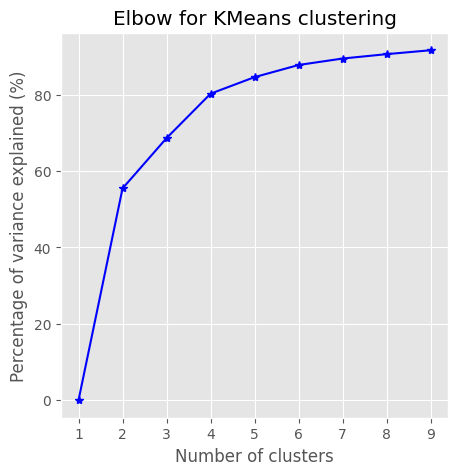

In [288]:
def plot_elbow(kmean, X):
    centroids = [k.cluster_centers_ for k in kmean]
    D_k = [cdist(X, center, 'euclidean') for center in centroids]
    dist = [np.min(D,axis=1) for D in D_k]

    # Total with-in sum of square
    wcss = [sum(d**2) for d in dist]
    tss = sum(pdist(X)**2)/X.shape[0]
    bss = tss-wcss

    plt.subplots(nrows=1, ncols=1, figsize=(5,5))
    ax = plt.subplot(1, 1, 1)
    ax.plot(Ks, bss/tss*100, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Percentage of variance explained (%)')
    plt.title('Elbow for KMeans clustering')
    plt.savefig('/Users/avaisman/tmp/PythonNotebooks/Figs/elbow.svg', format="svg", orientation ='landscape',bbox_inches ="tight", edgecolor ='g', dpi=250)
    plt.show()

plot_elbow(kmean, X)

In [57]:
lat = list(dfStInf['station_lat'])


In [58]:
lon = list(dfStInf['station_lng'])


In [59]:
 def plot_stations_map(ax, stns):
    # determine range to print based on min, max lat and lon of the data
    lat = list(stns['station_lat'])
    lon = list(stns['station_lng'])
    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    # create map using BASEMAP
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max - lon_min)/2,
                projection='lcc',
                resolution = 'f',)

    m.drawcoastlines()
    m.fillcontinents(lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')
    m.drawrivers()    
    
    # plot points
    clist = list(stns['cluster'].unique())
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, max(10, k))))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]        
        #print("Cluster {} has {} samples.".format(clist[i], df.shape[0]))
        
        # convert lat and lon to map projection coordinates
        lons, lats = m(list(df['station_lng']), list(df['station_lat']))        
        ax.scatter(lons, lats, marker = 'o', color=color, edgecolor='gray', zorder=5, alpha=1.0, s=15)

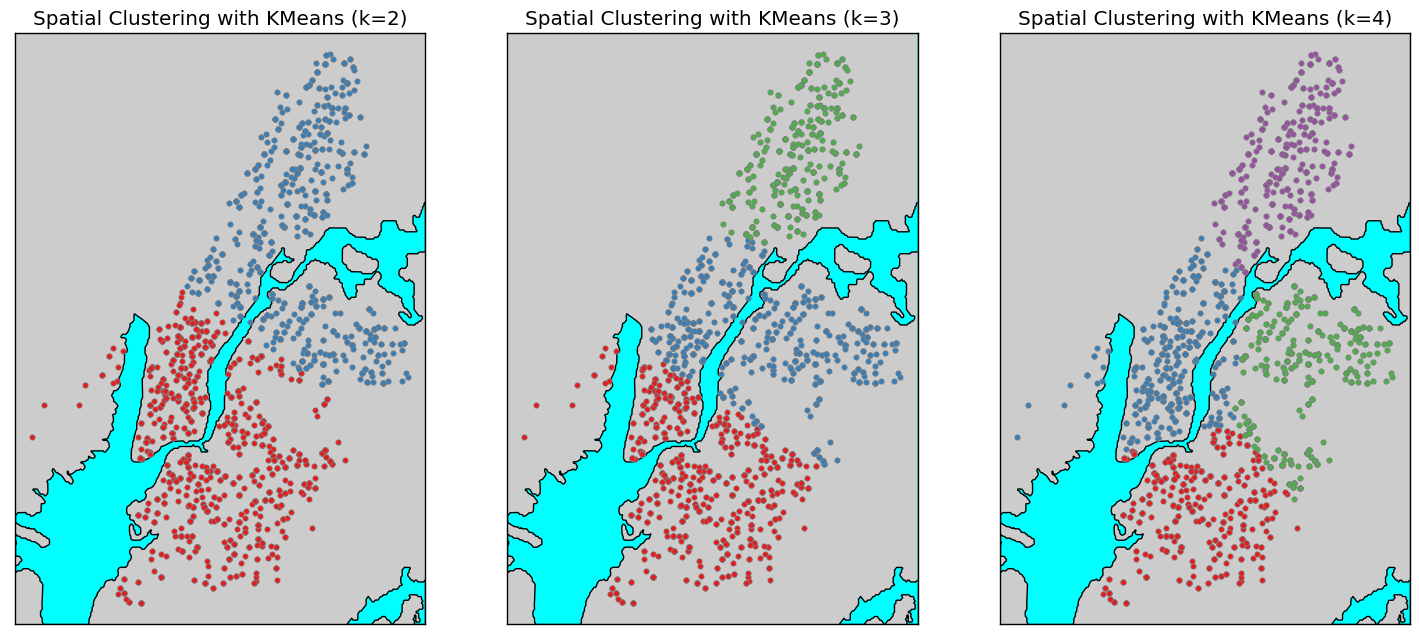

In [768]:
k = [2, 3, 4]
n = len(k)
plt.subplots(nrows=1, ncols=3, figsize=(18,15))
 

for i in range(n):
    est = kmean[k[i]-1]
    dfStInf['cluster'] = est.predict(X).tolist()
    ax = plt.subplot(1, 3, i+1)
    ax.set_title("Spatial Clustering with KMeans (k={})".format(k[i]))
    plot_stations_map(ax, dfStInf)
plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/kmeans-py.svg', format="svg",bbox_inches ="tight")

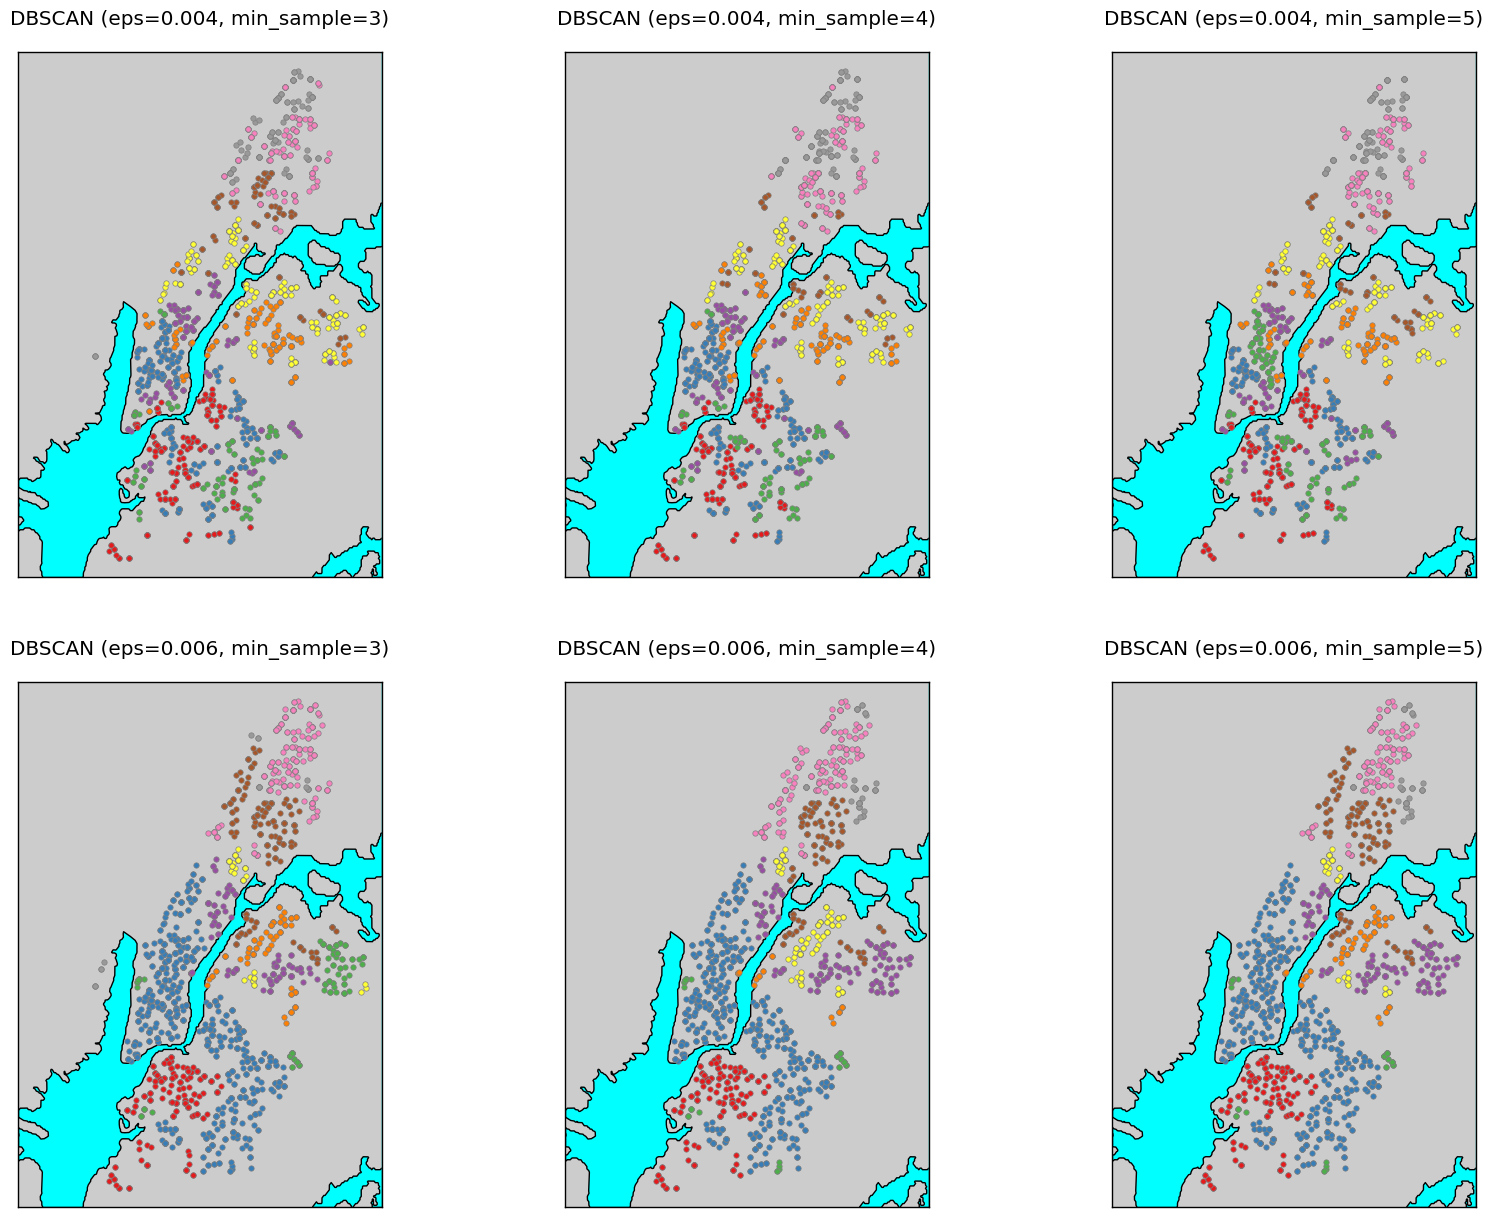

In [769]:
eps = [0.004, 0.006]   # unit: latitude/longitude
min_sample = [3, 4, 5]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n1, ncols=n2, figsize=(20, 15))

for i in range(n1):
    for j in range(n2):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric="euclidean").fit(X)
        dfStInf['cluster'] = est.labels_.tolist()

        ax = plt.subplot(n1, n2, n2*i+j+1)
        ax.set_title("DBSCAN (eps={}, min_sample={})".format(eps[i], min_sample[j]),pad=20)
        plot_stations_map(ax, dfStInf)
plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/dbscan-eu-abcdef.svg', format="svg",bbox_inches ="tight")

In [452]:
def greatCircleDistance(x, y):
    lat1, lon1 = x[0], x[1]
    lat2, lon2 = y[0], y[1]
    return geodesic((lat1, lon1), (lat2, lon2)).meters

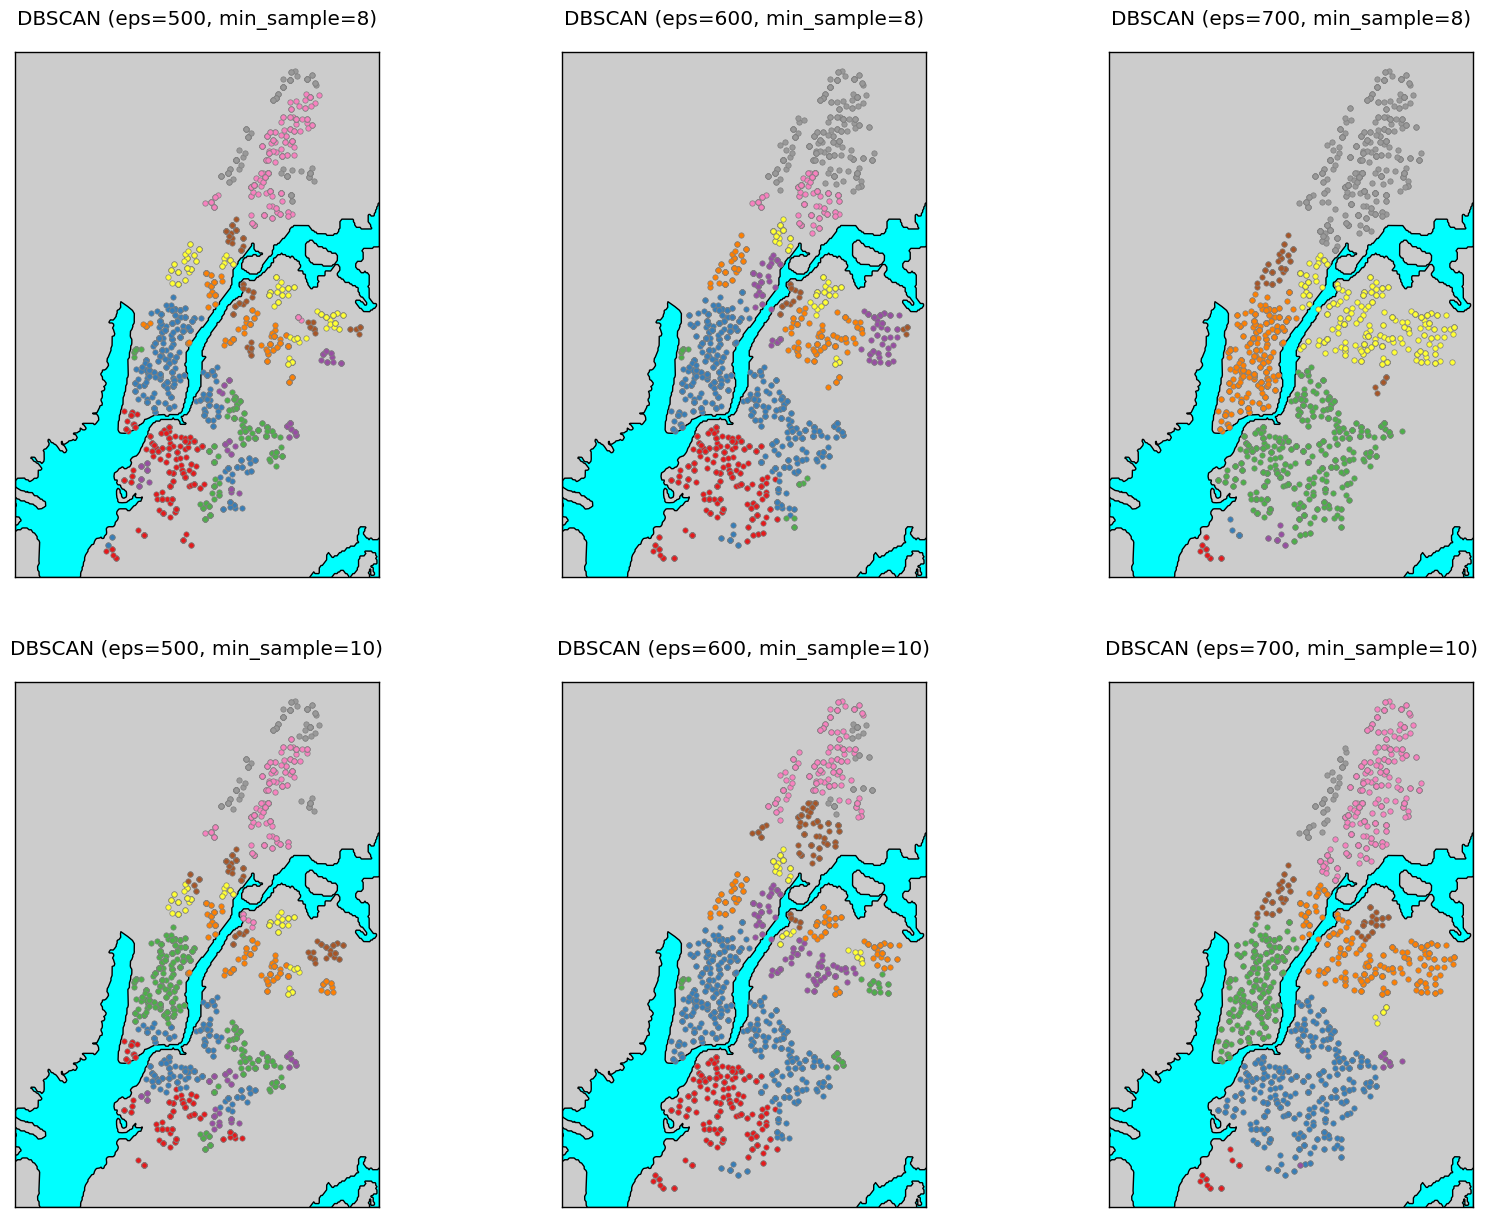

In [770]:
eps = [500, 600, 700]    # unit: meter
min_sample = [8, 10]
n1, n2 = len(eps), len(min_sample)
plt.subplots(nrows=n2, ncols=n1, figsize=(20, 15))

for j in range(n2):
    for i in range(n1):
        est = DBSCAN(eps=eps[i], min_samples=min_sample[j], metric=greatCircleDistance).fit(X)
        dfStInf['cluster'] = est.labels_.tolist()

        ax = plt.subplot(n2, n1, n1*j+i+1)
        ax.set_title("DBSCAN (eps={}, min_sample={})".format(eps[i], min_sample[j]), pad=20)
        plot_stations_map(ax, dfStInf)
plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/dbscan-gc-adbcef.svg', format="svg",bbox_inches ="tight")

In [111]:
 TEMPORAL CLUSTERING

In [289]:
X = df_temp.drop(["station_id"], axis=1).values
len(X)

2143

In [160]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        #plt.title('Hierarchical Clustering Dendrogram (truncated)')
        
        plt.title(' ')
        plt.xlabel('Sample Index', fontsize=30,labelpad=12)
        plt.ylabel('Distance', fontsize=30,labelpad=12)
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center',size=18)
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [163]:
def plot_dendrogram(Z, p, d):
    plt.figure(figsize=(25, 10))
    #plt.title('Hierarchical Clustering Dendrogram', pad=20)
    plt.plot(linewidth=14)
    plt.title(' ', )
    plt.xlabel('Sample Index',fontsize=30, labelpad=12)
    plt.ylabel('distance',fontsize=30,labelpad=12)
    fancy_dendrogram(
        Z,
        leaf_rotation=90,  # rotates the x axis labels
        leaf_font_size=18,  # font size for the x axis labels
        show_contracted=True,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=p,  # show only the last p merged clusters
        annotate_above=d,  # useful in small plots so annotations don't overlap
    )
    plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/dendogram.svg', format="svg",bbox_inches ="tight")
    plt.show()

In [63]:
df_All.columns

Index(['station_id', 'station_name', 'station_lat', 'station_lng', 'in_count',
       'in_count', 'in_count', 'in_count', 'in_count', 'in_count',
       ...
       'out_count', 'out_count', 'out_count', 'out_count', 'out_count',
       'out_count', 'out_count', 'out_count', 'out_count', 'out_count'],
      dtype='object', length=676)

In [21]:
def plot_flow_lines(ax, stns):
    clist = stns['cluster'].unique()
    if -1 in clist:
        clist.remove(-1)
    k = len(clist)
    colors = iter(cm.Set1(np.linspace(0, 1, 8)))
    for i in range(k):
        color = next(colors)
        df = stns.loc[stns['cluster'] == clist[i]]
        in_cols = list(filter(lambda x: 'in_count' in x, df_All.columns))
        out_cols = list(filter(lambda x: 'out_count' in x, df_All.columns))
        timeline = list(map(lambda x: x[1], in_cols))
        flows = df[in_cols].values + df[out_cols].values
        ax.plot(timeline, np.mean(flows, axis=0), color=color)
        #ax.plot(timeline, np.mean(flows, axis=0), color=color, alpha=0.3, linewidth=np.mean(np.std(flows, axis=0)))


In [ ]:
df_All['cluster']

In [64]:
len(df_All)

2143

In [192]:
def plot_agglomerative_clustering_result(df_All, Z, dist, affinity):
    n = len(dist)
    plt.subplots(nrows=n, ncols=1, figsize=(20, 15))

    for i in range(n):
        df_All['cluster'] = fcluster(Z, dist[i], 'distance')
        ax = plt.subplot(n, 1, 1*i+1)
        ax.set_title("Agglomerative Clustering (Linkage='{}', distance>{})".format(affinity, dist[i]))
        plot_stations_map(ax, df_All)
    plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/ward1.pdf', format="pdf",bbox_inches ="tight")
    plt.show()

In [154]:
affinity = 'single'
Z = linkage(X, affinity)
len(Z)

2142

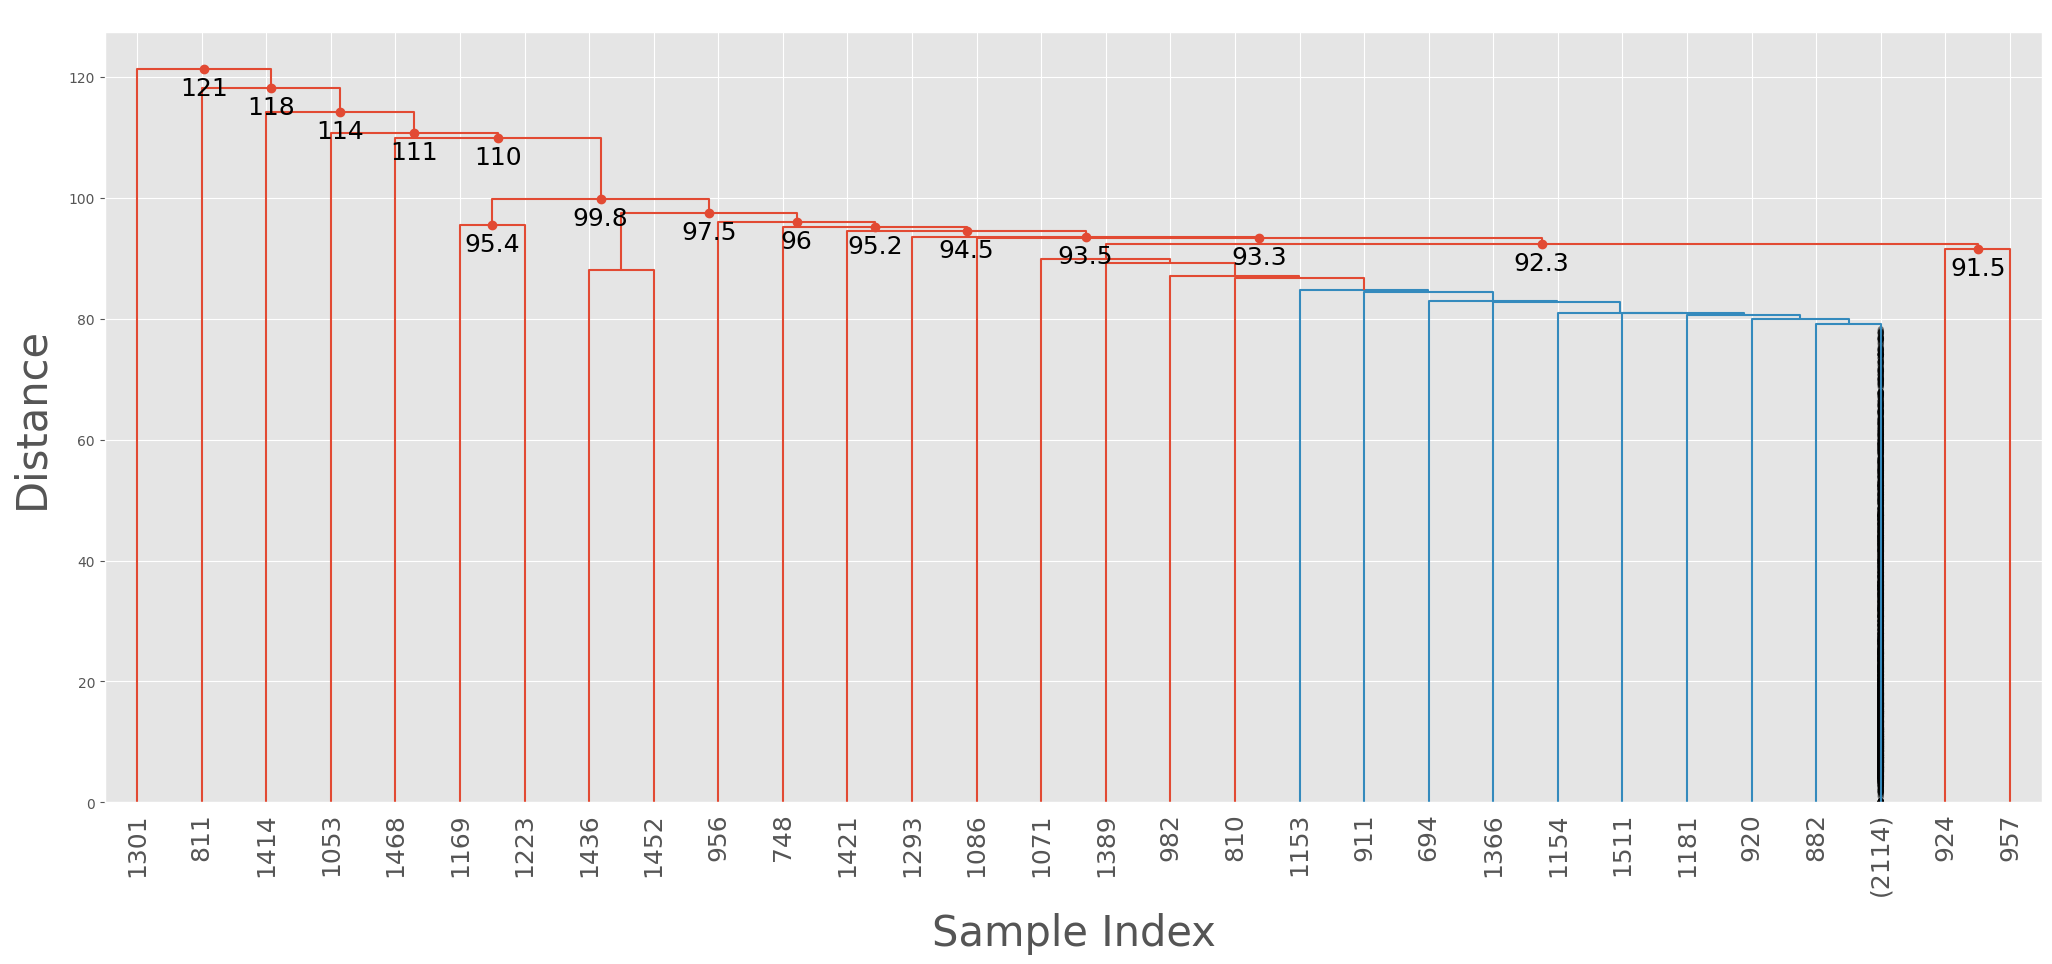

In [164]:
affinity = 'single'
Z = linkage(X, affinity)
plot_dendrogram(Z, 
                30,   
                90)

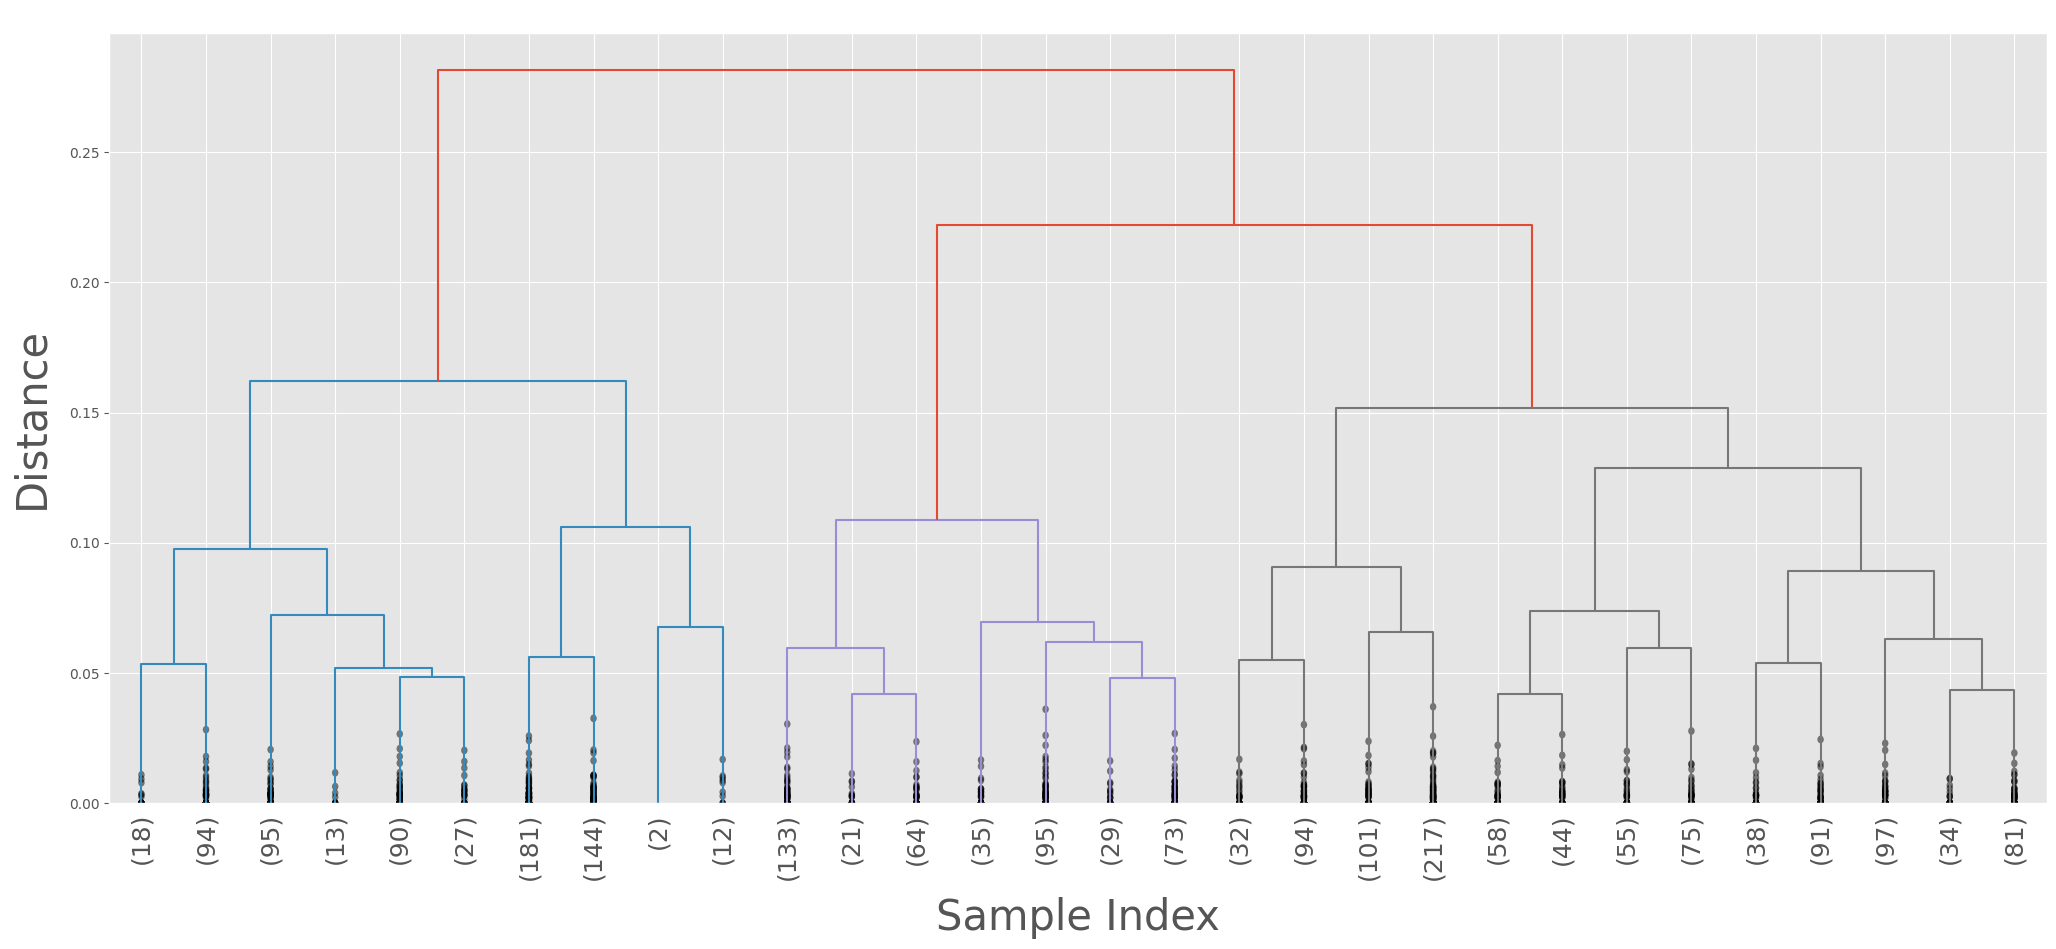

In [68]:
affinity = 'complete'
Z = linkage(X, affinity)
plot_dendrogram(Z, 
                30,   
                100)

In [ ]:
dist = [200, 70]
plot_agglomerative_clustering_result(df_All, Z, dist, affinity)

In [224]:
affinity = 'ward'
Z = linkage(X, affinity)
len(Z)

2142

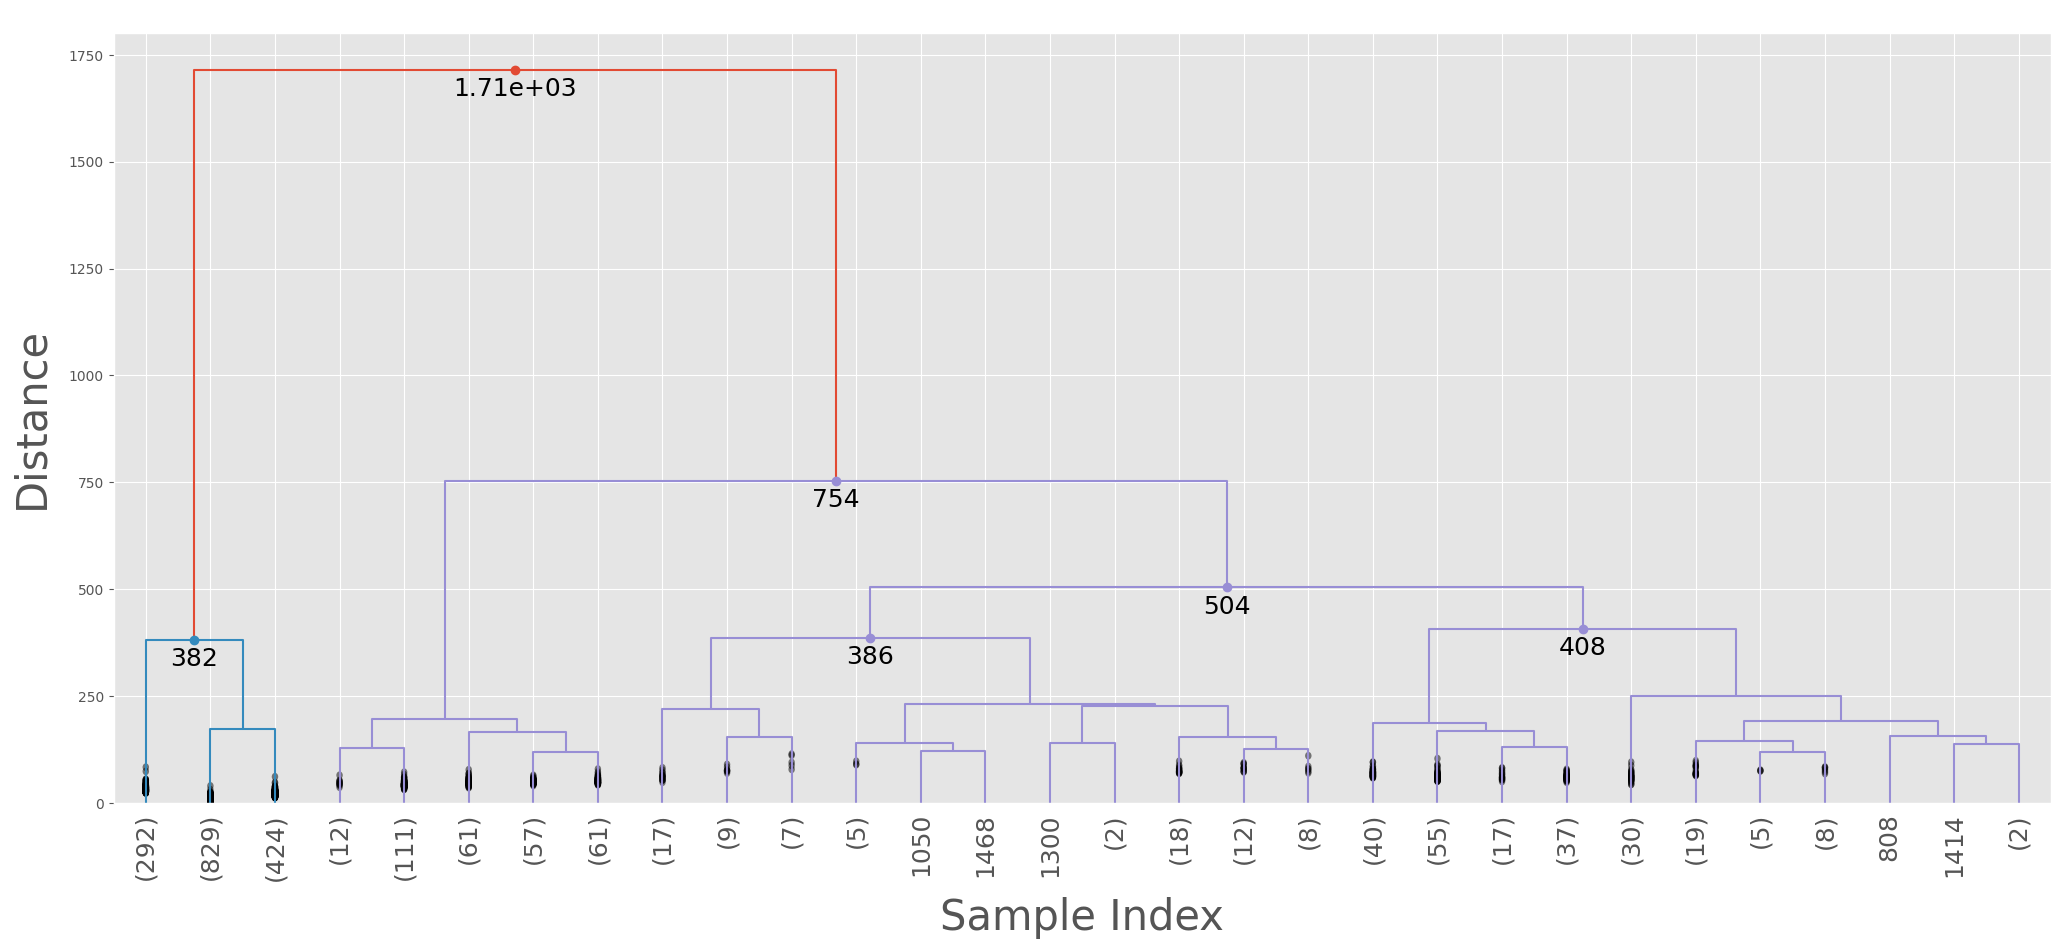

In [225]:
affinity = 'ward'
Z = linkage(X, affinity)
plot_dendrogram(Z, 
                30,    # only show the last 30 merges
                300)   # only annotates distance above 300

In [229]:
def plot_agglomerative_clustering_result_ward(df_All, Z, dist, affinity):
    n = len(dist)
    plt.subplots(nrows=1, ncols=n, figsize=(20, 15))

    for i in range(n):
        df_All['cluster'] = fcluster(Z, dist[i], 'distance')
        ax = plt.subplot(1, n, 1*i+1)
        #ax.set_title("Agg. Clust.(Linkage='{}', distance>{})".format(affinity, dist[i]))
        ax.set_title(" ".format(affinity, dist[i]))
        plot_stations_map(ax, df_All)
    plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/tempclustward-1-2-3.pdf', format="pdf",bbox_inches ="tight")
    plt.show()

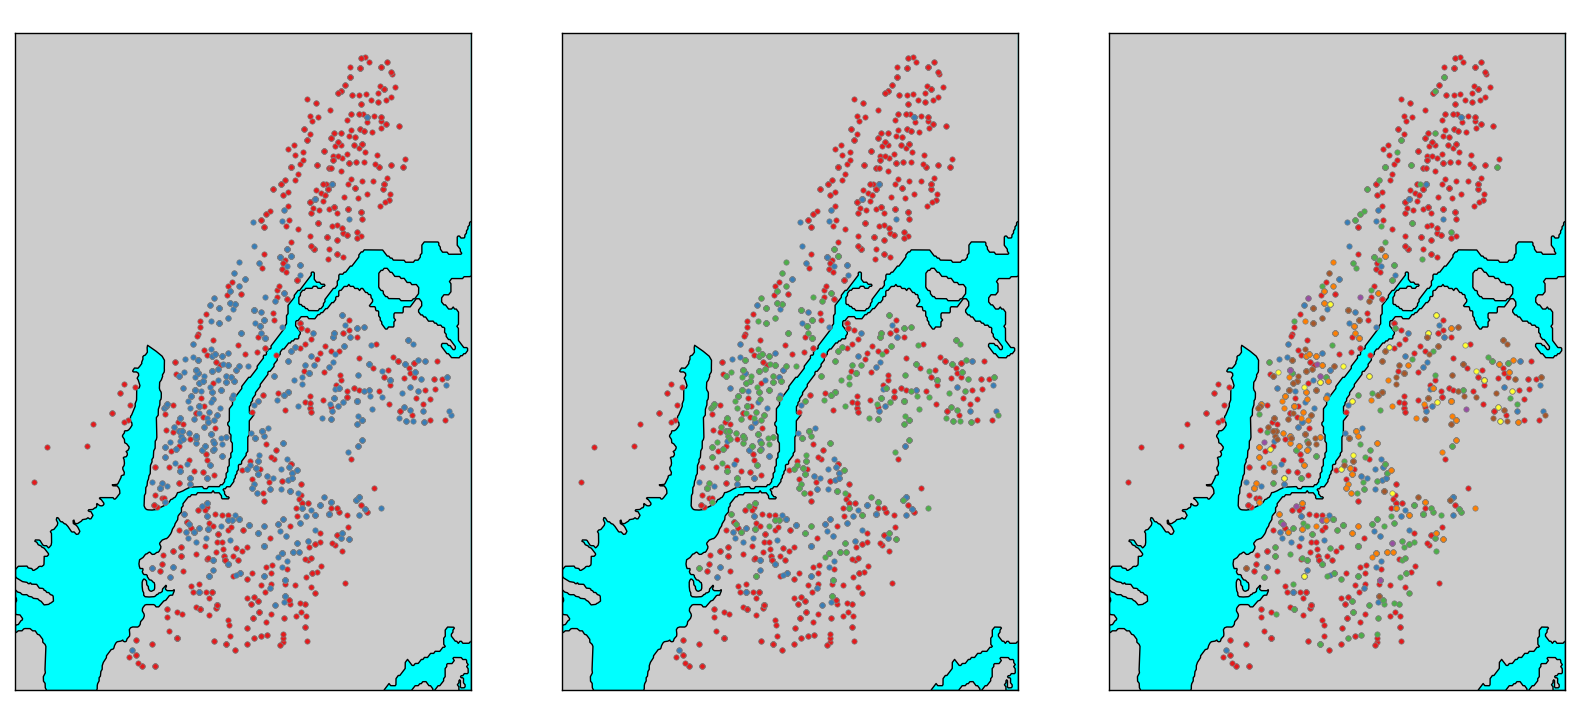

In [226]:
dist = [800, 600, 250]
plot_agglomerative_clustering_result_ward(df_All, Z, dist, affinity)

In [ ]:
Agglomerative Clustering with PCA 

In [228]:
n_components = 30
pca = PCA(n_components=n_components)
pca.fit(X)
X_pca = pca.transform(X)
len(X_pca)

2143

In [ ]:
#Principal Components Explained
plt.subplots(nrows=1, ncols=2, figsize=(15,6))
ax = plt.subplot(1, 1, 1)
ax.plot(range(1, n_components+1), 
        np.power(pca.singular_values_, 2)/sum(np.power(pca.singular_values_, 2)), 
        '.', markersize= 14)
plt.grid(True)
plt.xlabel('Principal Components',fontsize=22,labelpad=14)
plt.ylabel('Proportion of Variance Explained',fontsize=22,labelpad=14)
plt.title(' ')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/pcavar.pdf', format="pdf", dpi=250, bbox_inches ="tight")
plt.show()

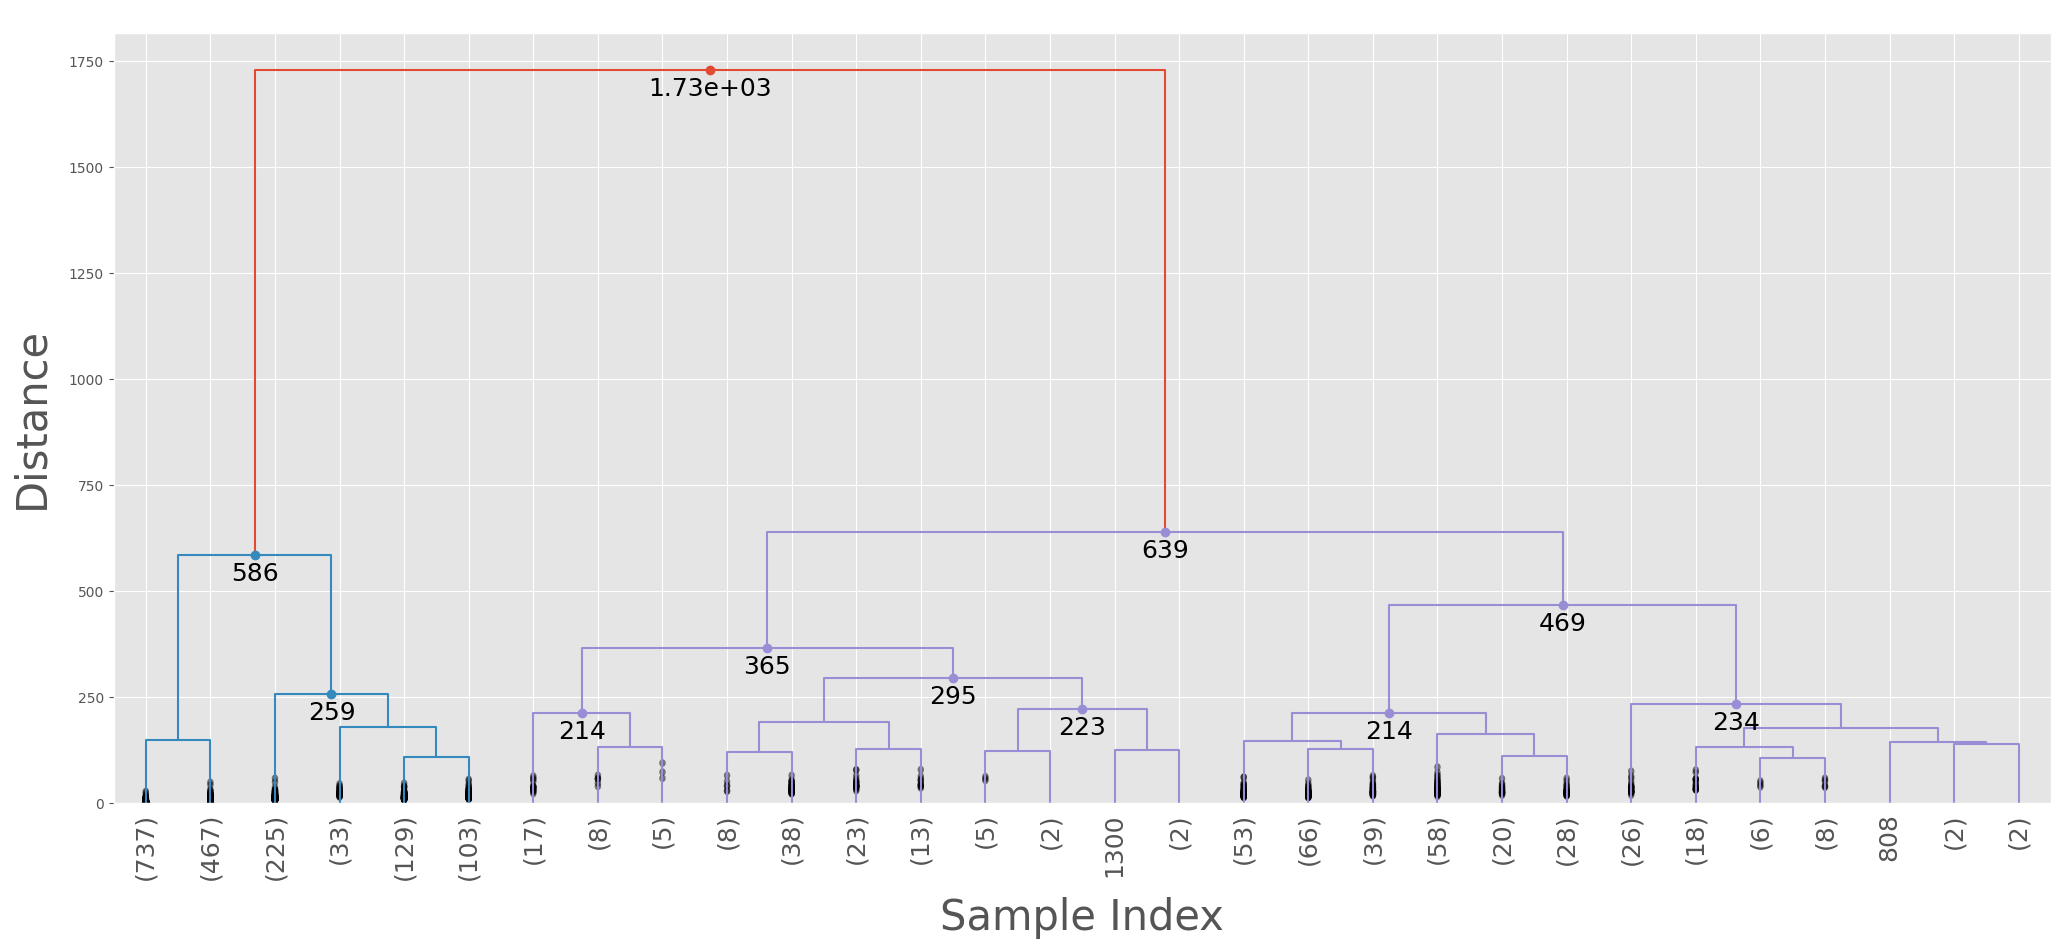

In [236]:
affinity = 'ward'
Z = linkage(X_pca, affinity)
plot_dendrogram(Z, 
                30,    # only show the last 30 merges
                200)

In [241]:
len(dist)
affinity
n_components
Z

array([[3.73000000e+02, 6.58000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.09500000e+03, 2.14300000e+03, 0.00000000e+00, 3.00000000e+00],
       [1.11100000e+03, 2.14400000e+03, 0.00000000e+00, 4.00000000e+00],
       ...,
       [4.26900000e+03, 4.27800000e+03, 5.86208865e+02, 1.69400000e+03],
       [4.28000000e+03, 4.28100000e+03, 6.39094231e+02, 4.49000000e+02],
       [4.28200000e+03, 4.28300000e+03, 1.72999127e+03, 2.14300000e+03]])

In [252]:
def plot_agglomerative_PCA_clustering_result(df_all, Z, dist, affinity, n_components):
    n = len(dist)
    plt.subplots(nrows=1, ncols=n, figsize=(20, 15))

    for i in range(n):
        df_All['cluster'] = fcluster(Z, dist[i], 'distance')
        ax = plt.subplot(1, n, 1*i+1)
        #ax.set_title("Agglomerative Clustering (n_components={}, distance>{})".format(n_components, dist[i]))
        ax.set_title(" ".format(dist[i]))
        plot_stations_map(ax, df_All)
    plt.savefig('/Users/avaisman/Dropbox/MobilityBook/Figs/MobilityAnalysis/pca_ward_800-600-250.pdf', format="pdf",bbox_inches ="tight",dpi=250)
    plt.show()

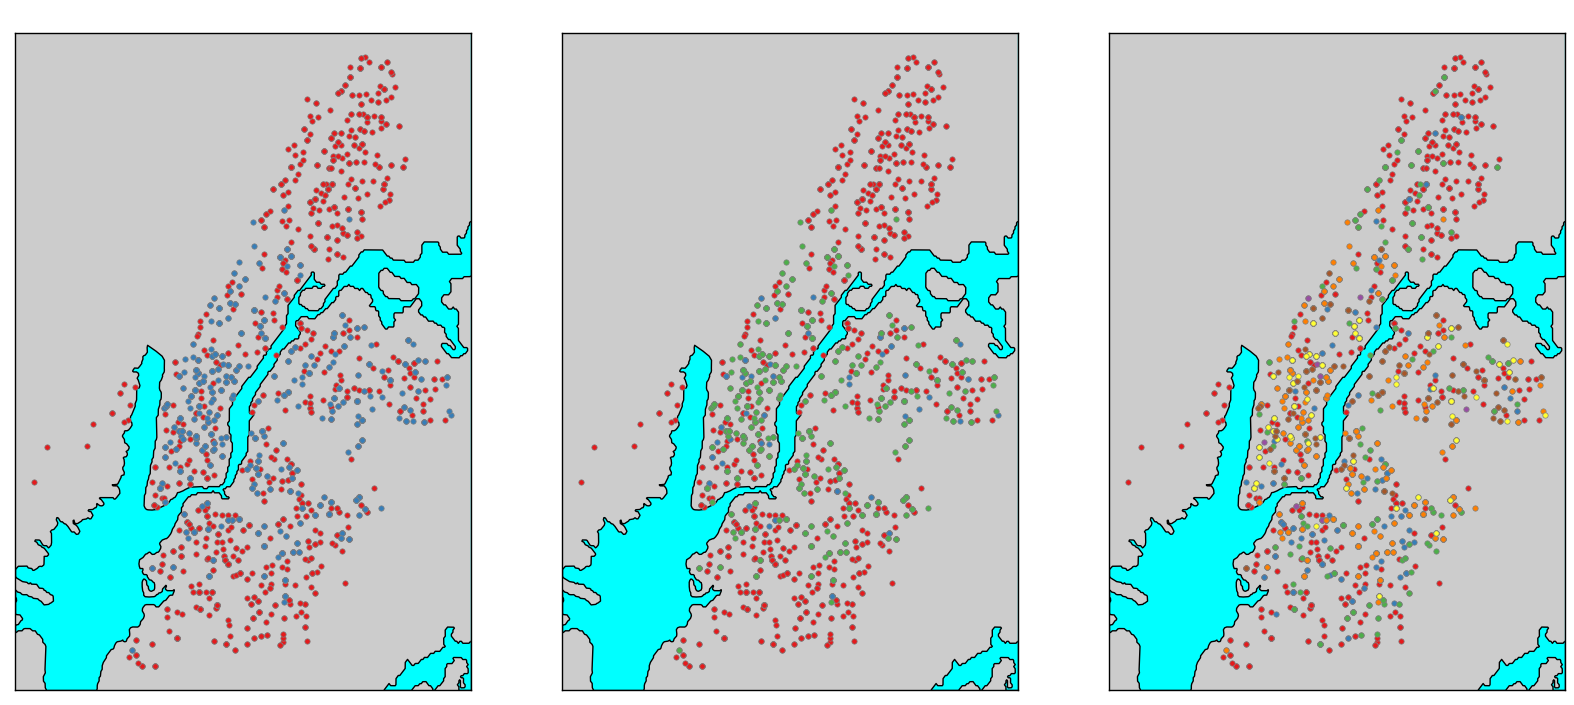

In [245]:
dist = [800, 600, 250]
plot_agglomerative_PCA_clustering_result(df_All, Z, dist, affinity, n_components)